In [1]:
N = 8
J_value = 1
J_matrix_alpha = 1

In [2]:
import numpy as np
from scipy.sparse.linalg import eigs
from scipy.sparse.linalg import eigsh
from scipy.interpolate import Akima1DInterpolator
from scipy.linalg import expm
import time
from scipy import sparse
import matplotlib.pyplot as plt
import pandas
import scipy
from scipy.interpolate import UnivariateSpline
import torch
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device( "cpu")
np.set_printoptions(precision=6)
# initialize variables

# Q is the dimension
Q = pow(2, N)

# decimal number to binary array function
def D2B(num):
    string = f'{num:1b}'
    result = np.zeros(N - len(string), int)

    for ele in string:
        result = np.append(result, int(ele))

    return result

def get_fidelity_torch(vector1, vector2):
    overlap = torch.tensordot(vector1, vector2, dims=1)
    overlap_conj = torch.conj(overlap)
    fidelity = torch.real(overlap * overlap_conj)
    return fidelity

def get_energy_torch(matrix, vector):
    conj_vector = torch.conj(vector)
    energy = torch.real(torch.tensordot(conj_vector, torch.tensordot(matrix, vector, dims=1), dims=1))

    return energy
    
# decimal number to binary array function
def D2B_with_digit(num,digit):
    string = f'{num:1b}'
    result = np.zeros(digit - len(string), int)

    for ele in string:
        result = np.append(result, int(ele))

    return result

# binary array to decimal function
def B2D(array):
    res = 0
    for ele in array:
        res = (res << 1) | ele
    return res

def spin_reflection(array):
    new_array = np.zeros(len(array),dtype=int)
    for i in range(len(array)):
        if array[i] == 1:
            new_array[i] = 0
        else:
            new_array[i] = 1
    return new_array

def spatial_reflection(array):
    new_array = array[::-1]
    return new_array

# start my main function

# initialize J matrix
J_matrix = np.zeros((N, N), dtype='float64')

for i in range(N):
    for j in range(N):
        if j >= (i + 1):
            J_matrix[i][j] = J_value/pow(abs(i-j),J_matrix_alpha)

In [3]:
best_x_30 = np.array([0.0936603564367677, 0.2051762001214427, 0.2463089094873932, 0.3901184422577069, -0.1566552695202834, 0.0952731242017399, 0.4823711229952712, 0.3229252099663475, -0.2894891838278786, 0.2446330166267743, 0.4091517928591440, 0.3411597524344765, 0.3767487235601615, 0.4096550299124064, 0.4360496642978115, 0.4406235887278616, 0.4510140521581578, 0.4562368196353694, 0.4700707130769085, 0.4851953143658400, 0.4751266474409635, 0.4587435694048260, 0.4484821150875642, 0.4706320058835329, 0.5032829673048763, 0.5531659862137859, 0.5902255542443087, 0.6063080390406458, 0.7405262870253992, 0.9533213780481534, -1.5217628565839387, 0.5229050589704566, 1.9274298721988705, 0.2749883070349547, 1.0406904148110370, 0.1010325783319367, 0.8281348694198741, 0.1540480924718009, 1.2098262607889863, 0.0524561782550547, 0.5956815851714431, 0.1799565723772132, 0.1895626101278335, 0.1970029573300717, 0.2071430427837794, 0.2010495184863038, 0.1963274483645235, 0.1948801434805197, 0.1993824098776083, 0.2023461969345260, 0.1942961329180070, 0.1772497714992665, 0.1680109352275089, 0.1719426437094280, 0.1818287948352202, 0.1802819305886998, 0.1725549275552033, 0.1578787108300562, 0.1319753198628043, 0.0776464838585328, 0.0384578846102251
                     ])

In [4]:
best_x_40 = np.array([0.10171197978282819, 0.23452263551077265, 0.2952944661308091, 0.40385027514921074, 0.130342711921415, -0.14192665294318357, 0.0009319262241798356, 0.17465933035710773, 0.30328653708132747, 0.022175513479698896, -0.16381688925989615, 0.14714399515098756, 0.24646436585398665, 0.27225338663953536, 0.18171896629196949, 0.24254101578830498, 0.22648926354028687, 0.371302473440885, 0.41229610464063765, 0.4322392645866204, 0.4602484919360992, 0.46620704718060835, 0.46119266357261457, 0.4649399002898082, 0.4770361823649284, 0.14396855569152361, 0.26491041359521494, 0.48578830024662717, 0.5009502419692582, 0.4968982486411721, 0.4096111073480211, 0.4200095671459159, 0.5343891503746732, 0.5931448563835003, 0.6259242735938608, 0.651564460480234, 0.6621492143444425, 0.6469747883356498, 0.6265284901100269, -7.468275816880233e-05, 0.5574354751967595, 0.41534558872731425, 0.33550363262275934, 0.36568469716398294, 1.0029423964087087, 0.14332399868351758, 0.08352346859052899, 0.41382448962304436, 0.6321751394720654, 0.6108124435012142, 0.19213210851960102, 0.4089521907521196, 0.13342546686202736, 0.13038153395228733, 0.12597696249633739, 0.11133388641379938, 0.16646075029552349, 0.20537932939067066, 0.2072085211817601, 0.21256510098138862, 0.21464938181866655, 0.20655477846183423, 0.20136535685740226, 0.1983675760093686, 0.2526658774768438, -0.10612464240174381, 0.2199151701037883, 0.19689528554217342, 0.19740107294634043, 0.16877635703005778, 0.13147520846091537, 0.15941073016627902, 0.1769598762144772, 0.17281720170426598, 0.15968149727658423, 0.13944710014386455, 0.12225148380809951, 0.10126538918195123, 0.050545854158937385])

In [5]:
best_x_60 = np.array([0.0609189168862844, 0.1519214777441040, 0.2177415558803502, 0.2775193392884092, 0.3148216564476874, 0.3233111475294995, 0.1875038654151858, 0.0802059993046237, -0.0722005506934682, -0.0109992027318399, 0.1034454299434343, 0.2126645985165376, 0.1502326581335771, -0.0385744412036069, 0.0563074777331458, 0.0274769434471584, 0.1441146488276454, -0.0990232575527071, -0.0763582677431228, -0.0805861001932164, 0.4376096923205982, 0.0102732749443041, 0.3675225437702748, 0.0077309900566174, 0.3961507922020510, 0.4303347067657325, 0.4153958775139957, 0.3959655950139763, 0.3731580896306516, 0.1688493608470218, 0.0329773079660679, 0.3615461136263413, 0.2265199481217018, 0.3456313725681977, 0.4466686698126207, -0.1362958751404506, 0.1975086207421070, 0.2263939347861471, 0.1215174798477647, 0.4351273407165654, 0.4826779708629020, 0.5028489299117584, 0.4789525803862550, 0.3940024499136431, 0.4156170770179988, 0.5034729451142987, 0.3321173102325121, 0.2885091048543854, 0.5634063294709696, 0.4849027111137416, 0.1583340293792161, 0.5878695911352591, 0.6186049717051209, 0.6312562827934277, 0.6379517184737654, 0.6447879540097436, 0.6414871922308933, 0.6141203929569636, 0.7006991994543212, -0.4465979198001656, 0.5791193829417574, 0.4453380939813435, 0.3874578645914323, 0.3444996985468358, 0.3038575339719551, 0.2631731332415791, 1.0984050827391902, -0.0795498995011945, 0.3087893298063697, 0.1912233691977209, 0.3194203215179484, -0.2155506234398110, 0.4467787396091157, -0.6239973840523872, 0.0298806595169625, 1.2181757475500294, -0.0188769942126243, 0.1837741170896478, 0.1701580609038909, 0.5684514934605466, 0.3200375380088773, -0.0838440008214065, 0.3949919193676327, -0.1660981668713009, 0.2386447734958723, 0.2269210363419732, 0.2042222212119692, 0.1934671490225616, 0.1447105675560622, -0.0648493313572199, 0.1777572668716369, 0.1561655658629411, 0.0963838146275836, 0.1854511568567686, 0.0449256855580622, 0.0409098983677676, 0.1304070590594006, -0.0502732788478662, 0.2000656805526236, 0.1922185462097727, 0.2031341807570012, 0.1973452629285435, 0.1680356376573205, 0.1374432203433954, 0.1655656761424308, 0.1678715627658535, 0.0427045192878163, 0.1597659230236304, 0.1662670312688279, 0.0429169407729353, 0.1302722050512265, 0.1549782709696887, 0.1480778858806875, 0.1369344092373340, 0.1236394515539423, 0.1084908104755546, 0.0938411519505762, 0.0701163530541828, 0.0092803998512390
                     ])

In [6]:
best_x_50 = np.array([0.0647514601591052, 0.166394162798547, 0.23885485178177834, 0.2977756720036629, 0.3171800000402093, 0.317166918392768, 0.05006511042372438, -0.10688439902826523, 0.03267311162764664, 0.13138043563285215, 0.27608374845393663, 0.07356910175871981, 0.052182695467071404, -0.0449525161461456, 0.04198885454358715, -0.11726646539205779, 0.2405284379426732, 0.18941293127690878, 0.1387646575258391, 0.40865359647160937, 0.3779846647216628, 0.37529116928772227, 0.4144323733220048, 0.33372257996210575, 0.32150891797881903, 0.434124463500779, 0.40054997132402764, 0.33096603116478807, 0.12273102762645025, 0.4257643960860163, 0.48521023128211, 0.44952743155821606, 0.4124433224159519, 0.4283018118365142, 0.4259419374351622, 0.26513183842370797, 0.33980724480110364, 0.4817507239408005, 0.4276029813202166, 0.336890397121883, 0.5253984858056244, 0.6077905149020423, 0.6371120063976905, 0.650904065732478, 0.6603734261841776, 0.6656661168414477, 0.6609086600094088, 0.6360416306833484, 0.7384115567156863, -0.44648590649258657, 0.5811476104640556, 0.4429248974328886, 0.37977372162011896, 0.32836383057161855, 0.262135243565093, 0.5179785734016681, 0.15336538195732807, 0.22439769856744937, 1.0236263551767855, -0.09846438150531468, 0.32963401369110473, -0.20887845804063954, 0.4925351181910959, 0.6406315513599943, 0.2612397663096956, 0.287050914640353, 0.2322524134465559, -0.09683176112448078, 0.2793532813014199, 0.2277342393071619, 0.19570045326936453, 0.20589853129879387, 0.19730044879530928, 0.1347117671465006, 0.18768287964585437, 0.19856202232227085, 0.1621522384708093, 0.09000564675852356, 0.11376002225669386, 0.20262229995625822, 0.1976416244474579, 0.17306117228923742, 0.16572085261048386, 0.1676880410401238, 0.14160388671238536, 0.07927393829958533, 0.1564703026645255, 0.159617761756837, 0.10626419107039968, 0.12847612388008217, 0.1634510900549965, 0.16546790380043963, 0.15903652531503187, 0.1487628435618338, 0.13640592803122942, 0.12057432995991971, 0.10455827677828057, 0.08112377580490084, 0.01368310839293342
                     ])

In [7]:
best_x_80 = np.array([-0.0424810948602934, 0.1026983223523859, -0.0398203507203160, 0.0836624294244694, 0.0293409698141539, 0.0692511547390258, 0.1359321274655585, 0.0337479959657929, 0.0313542517954505, -0.0160107978823175, -0.0038296421875186, -0.0251281392154148, 0.0335188620280699, 0.0255951456872216, 0.0323774603054501, 0.0879004579308568, 0.0317613280137807, 0.0397191651820374, -0.0062877337211761, 0.0129321069890765, -0.0083762262934412, -0.0030142610156823, 0.0002009346621893, -0.0098269153182629, 0.0440232219966633, 0.0714799780396456, 0.0404802514388464, 0.2076326889114722, 0.2196177798717421, 0.2000022151128549, 0.1852012481406474, 0.1756013666278461, 0.2325435730643387, 0.2486271327096015, 0.2801867104213627, 0.2803683500401855, 0.2767868403404265, 0.2849349778280637, 0.2786451424271765, 0.2884720286868525, 0.2641904821853455, 0.2531488321351231, 0.2566299974546563, 0.2037140733560354, 0.2328532284709324, 0.2350035229940139, 0.1765730371597180, 0.2358295330106763, 0.2653149982296147, 0.2578171220023170, 0.3016246882468108, 0.3262253226243042, 0.3421577962144998, 0.3543674968676780, 0.3571845087432406, 0.3457550467087496, 0.3284676569104938, 0.3262328568620657, 0.2878917507213414, 0.2988148592562949, 0.3189415766323391, 0.2893447993254001, 0.3648238896003053, 0.3832776346362605, 0.3776656045480822, 0.3630740028520964, 0.3658649791173486, 0.3642662009535073, 0.3675156559185244, 0.4163574952479840, 0.4532761822312315, 0.4779679829553732, 0.4761104618726156, 0.4270503630334642, 0.4312346406518344, 0.4875343124179262, 0.4820215299411769, 0.4426394496195690, 0.4428076503736208, 0.3739830573751433, -0.0648600844637029, 0.0175641643753809, 0.2214662995623984, 0.2765745745375634, 0.2000794534124461, 0.2204223487278709, 0.2599260811950088, 0.2707747814430673, 0.2778764780442392, 0.2978668036750617, 0.3298314847318548, 0.2340864076625876, 0.2091803386239040, 0.1339610963473810, 0.2051072717132403, 0.1045927062259071, 0.0905710645359705, 0.1364647912890238, 0.1959662046276549, 0.2456281696405663, 0.2226763094302379, 0.2523416253527972, 0.1898406131440128, 0.1582196093852772, 0.1206408015244746, 0.1309849408022672, 0.1719918871154317, 0.0903176903577139, 0.2332607512748363, 0.1830926161061901, 0.1692165205246689, 0.1217904221639259, 0.1575235755080769, 0.1622012534462155, 0.1732579040934091, 0.1751289527393548, 0.1624752314826566, 0.1597082069042098, 0.1539202257814358, 0.1489885928594471, 0.1457790292606851, 0.1232788476859944, 0.1292244504781225, 0.1088648133478620, 0.0974302094382964, 0.1140190303946814, 0.0923122792585590, 0.0851280129082342, 0.1179625449624150, 0.1104569842362780, 0.1197464229698605, 0.1341276915423285, 0.1393231279712631, 0.1432866509490482, 0.1441125715378980, 0.1397419942351713, 0.1295410986642254, 0.1228411823047366, 0.1154256417860978, 0.0971182244592765, 0.1136793852547967, 0.0966088037732524, 0.1061858764183808, 0.1193293312634662, 0.1135635880330005, 0.1056784916077666, 0.0978770797464761, 0.0963946701077432, 0.0891137592534112, 0.0932726328190429, 0.0992259905968961, 0.0995492556451432, 0.0953359083769773, 0.0824899756378670, 0.0685866033239505, 0.0714994327194024, 0.0694346127887010, 0.0590905468096387, 0.0518278227376197, 0.0479021135668921, 0.0122408262598471])

In [10]:
location =(len(best_x_30)//2+1)
print(location)
# x_A = best_x_40[:location]
# x_B = best_x_40[location:]

31


In [31]:
# # supplemental material

# plt.figure(figsize=(6,4))
# plt.plot(np.linspace(0,1, len(best_x_60[:59])), best_x_60[:59],color='orange',lw=3)  
# plt.plot(np.linspace(0,1, len(best_x_60[60:])), best_x_60[60:],color='blue',lw=3)  


# plt.xticks(np.arange(0, 1.2, 0.2), fontsize=15)

# # Set y-axis ticks and adjust font size
# plt.yticks(fontsize=15)

# # Set x-axis label with adjusted font size
# plt.xlabel('normalized time', fontsize=15)

# # # Set the first y-axis label
# # plt.ylabel(r'$\gamma$', fontsize=24, color='red')

# # Set the second y-axis label as an annotation
# plt.text(0.85, 0.8, r'$\gamma (t)$', fontsize=24, color='orange', transform=plt.gca().transAxes, va='center', rotation=0)
# # Set the second y-axis label as an annotation
# plt.text(0.3, 0.2, r'$\beta (t)$', fontsize=24, color='blue', transform=plt.gca().transAxes, va='center', rotation=0)


# # plt horizontal line 
# plt.axhline(y = 0, color = 'black', linestyle = 'dashed',lw=3)  

# plt.tight_layout()
# plt.savefig(f'supplemental_QAOA_angle')

In [32]:
# # noisey ratio 

# # y_60=best_x_60[60:]/ best_x_60[:59]
# # plt.plot(y_60,'o')
# # plt.ylim(0,1)

# plt.plot(np.linspace(0,1, len(B_data_smooth)), B_data_smooth,color='black',linewidth=3)
# plt.plot(np.linspace(0, 1, len(y_60)), y_60, 'o',color='r',markersize=6)
# plt.plot(np.linspace(0, 1, len(y_60)), y_60,'--',color='r',alpha=0.4)
# plt.ylim(-10,10)
# plt.yticks([-10,-5,0,5,10],fontsize=15)
# plt.xticks(fontsize=15)
# # Improved arrow using annotation
# plt.annotate('local adiabatic field', xy=(0.3, 0.3), xytext=(0.9, -3),
#              arrowprops=dict(facecolor='black', shrink=0.05, headwidth=7, headlength=10, width=1),
#              fontsize=16, color='black', horizontalalignment='right')

# plt.annotate('QAOA ratio', xy=(0.52, 3), xytext=(0.9, 5),
#              arrowprops=dict(facecolor='red', edgecolor='red', shrink=0.05, headwidth=7, headlength=10, width=1),
#              fontsize=15, color='red', horizontalalignment='right')

# # Set x-axis label with adjusted font size
# plt.xlabel('normalized time', fontsize=15)

# # Set y-axis label with adjusted font size
# plt.ylabel('B(t)', fontsize=15)

In [33]:
# read B field file 
time_and_B_data = pandas.read_csv(f"B_profile_N={8}_a={1}_B_start={10}_B_0={0.1}.csv")
time_list = time_and_B_data['time'].to_numpy()
B_list = time_and_B_data['B'].to_numpy()
number_of_layers = 1000

bi = Akima1DInterpolator(time_list, B_list)
t_data_smooth = np.linspace(min(time_list), max(time_list),number_of_layers)# Number of steps to take for time evolution 
B_data_smooth = bi(t_data_smooth)
print( 'number of layers is', number_of_layers)

number of layers is 1000


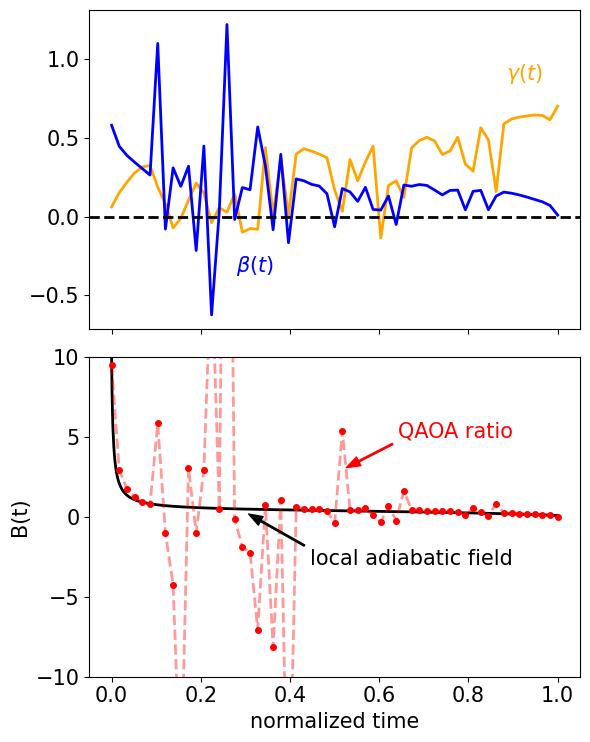

In [35]:
# Define font size and linewidth for consistency
font_size = 15
line_width = 2

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

# First subplot
axs[0].plot(np.linspace(0, 1, len(best_x_60[:59])), best_x_60[:59], color='orange', lw=line_width)
axs[0].plot(np.linspace(0, 1, len(best_x_60[60:])), best_x_60[60:], color='blue', lw=line_width)
axs[0].axhline(y=0, color='black', linestyle='dashed', lw=line_width)
axs[0].text(0.85, 0.8, r'$\gamma (t)$', fontsize=font_size, color='orange', transform=axs[0].transAxes, va='center', rotation=0)
axs[0].text(0.3, 0.2, r'$\beta (t)$', fontsize=font_size, color='blue', transform=axs[0].transAxes, va='center', rotation=0)

# Second subplot
y_60=best_x_60[60:]/ best_x_60[:59]
axs[1].plot(np.linspace(0, 1, len(B_data_smooth)), B_data_smooth, color='black', linewidth=line_width)
axs[1].plot(np.linspace(0, 1, len(y_60)), y_60, 'o', color='red', markersize=4)
axs[1].plot(np.linspace(0, 1, len(y_60)), y_60, '--', color='red', alpha=0.4, lw=line_width)
axs[1].annotate('local adiabatic field', xy=(0.3, 0.3), xytext=(0.9, -3),
                arrowprops=dict(facecolor='black', shrink=0.05, headwidth=7, headlength=10, width=1),
                fontsize=font_size, color='black', horizontalalignment='right')
axs[1].annotate('QAOA ratio', xy=(0.52, 3), xytext=(0.9, 5),
                arrowprops=dict(facecolor='red', edgecolor='red', shrink=0.05, headwidth=7, headlength=10, width=1),
                fontsize=font_size, color='red', horizontalalignment='right')
axs[1].set_ylim(-10, 10)
axs[1].set_yticks([-10, -5, 0, 5, 10])
axs[1].set_ylabel('B(t)', fontsize=font_size)
axs[1].set_xlabel('normalized time', fontsize=font_size)
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=font_size)

# Adjust layout
plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.savefig('noisy_QAOA.pdf')
plt.show()


In [30]:
# plt.figure(figsize=(7,5))
# plt.plot(np.linspace(0,1, len(best_x_30[:30])), best_x_30[:30],color='red',linewidth=2)

# plt.plot(np.linspace(0,1, len(best_x_50[:49])), best_x_50[:49],color='orange',linewidth=2)

# plt.plot(np.linspace(0,1, len(best_x_80[:80])), best_x_80[:80],color='blue',linewidth=2)


# plt.xticks(np.arange(0, 1.2, 0.2), fontsize=20)

# # Set y-axis ticks and adjust font size
# plt.yticks(fontsize=20)

# # Set x-axis label with adjusted font size
# plt.xlabel('normalized time', fontsize=20)

# # Set y-axis label with adjusted font size
# plt.ylabel(r'$\gamma (t)$', fontsize=24,color='black')

# # insert label 

# plt.text(x=0.8, y=0.15, s='80 layers', color='blue', fontsize=20, ha='center')
# plt.text(x=0.5, y=0., s='50 layers', color='orange', fontsize=20, ha='center')
# plt.text(x=0.32, y=0.5, s='30 layers', color='red', fontsize=20, ha='center')


# plt.tight_layout()
# plt.savefig(f'QAOA_angle_gamma')

In [16]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming your data arrays are defined as best_x_30, best_x_50, best_x_80

# plt.figure(figsize=(7, 5))

# # Plotting with different line styles and markers
# plt.plot(np.linspace(0, 1, len(best_x_30[:30])), best_x_30[:30], color='red', linewidth=2, linestyle='-', marker='o', markersize=5, label='30 layers')
# plt.plot(np.linspace(0, 1, len(best_x_50[:49])), best_x_50[:49], color='orange', linewidth=2, linestyle='--', marker='s', markersize=5, label='50 layers')
# plt.plot(np.linspace(0, 1, len(best_x_80[:80])), best_x_80[:80], color='blue', linewidth=2, linestyle='-.', marker='^', markersize=5, label='80 layers')

# # Adjust x-axis ticks and font size
# plt.xticks(np.arange(0, 1.2, 0.2), fontsize=20)

# # Set y-axis ticks and adjust font size
# plt.yticks(fontsize=20)

# # Set x-axis label with adjusted font size
# plt.xlabel('normalized time', fontsize=20)

# # Set y-axis label with adjusted font size
# plt.ylabel(r'$\gamma$', fontsize=24, color='black')

# # Insert labels
# plt.text(x=0.8, y=0.15, s='80 layers', color='blue', fontsize=20, ha='center')
# plt.text(x=0.5, y=0.0, s='50 layers', color='orange', fontsize=20, ha='center')
# plt.text(x=0.32, y=0.55, s='30 layers', color='red', fontsize=20, ha='center')

# plt.tight_layout()
# plt.legend(fontsize=15)
# plt.savefig('QAOA_angle_gamma')

# plt.show()


In [17]:
# plt.figure(figsize=(7,5))
# plt.plot(np.linspace(0,1, len(best_x_30[31:])), best_x_30[31:],color='red',linewidth=2)

# plt.plot(np.linspace(0,1, len(best_x_50[50:])), best_x_50[50:],color='orange',linewidth=2)

# plt.plot(np.linspace(0,1, len(best_x_80[81:])), best_x_80[81:],color='blue',linewidth=2)

# plt.xticks(np.arange(0, 1.2, 0.2), fontsize=20)

# # Set y-axis ticks and adjust font size
# plt.yticks(fontsize=20)

# # Set x-axis label with adjusted font size
# plt.xlabel('normalized time step', fontsize=20)

# # Set y-axis label with adjusted font size
# plt.ylabel(r'$\beta$', fontsize=24,color='black')

# plt.tight_layout()
# plt.savefig(f'QAOA_angle_beta')

In [18]:
# plt.figure(figsize=(7,5))
# plt.plot(np.linspace(0,1, len(best_x_30[31:])), best_x_30[31:],color='red',linewidth=2)

# plt.plot(np.linspace(0,1, len(best_x_50[50:])), best_x_50[50:],color='orange',linewidth=2)

# plt.plot(np.linspace(0,1, len(best_x_80[81:])), best_x_80[81:],color='blue',linewidth=2)

# plt.xticks(np.arange(0.4, 1.2, 0.2), fontsize=30)
# plt.xlim(0.4,1)
# plt.ylim(0,0.3)

# # Set y-axis ticks and adjust font size
# plt.yticks(np.arange(0.05, 0.3, 0.1), fontsize=30)

# # Set x-axis label with adjusted font size
# # plt.xlabel('normalized time step', fontsize=20)

# # Set y-axis label with adjusted font size
# plt.ylabel(r'$\beta$', fontsize=30,color='black')

# plt.tight_layout()
# plt.savefig(f'QAOA_angle_beta_inset')

In [19]:
# import numpy as np

# def keep_monotonic_decreasing(data):
#     if len(data) == 0:
#         return np.array([]), np.array([])

#     # Initialize the result lists with the first element
#     kept_indices = [0]
#     kept_elements = [data[0]]

#     # Iterate through the data starting from the second element
#     for i in range(1, len(data)):
#         if data[i] < kept_elements[-1]:
#             kept_indices.append(i)
#             kept_elements.append(data[i])

#     return np.array(kept_indices), np.array(kept_elements)


In [20]:
# fitted_x,fitted_y = keep_monotonic_decreasing(y)

In [22]:
# get y , which is the ratio 
# y_40=best_x_40[40:]/ best_x_40[:39]

# y_60=best_x_60[60:]/ best_x_60[:59]

y_80=best_x_80[81:]/ best_x_80[:80]

y_30=best_x_30[31:]/ best_x_30[:30]

y_50=best_x_50[50:]/ best_x_50[:49]

In [23]:
# plt.figure(figsize=(7,5))
# plt.plot(np.linspace(0,1, len(B_data_smooth)), B_data_smooth,color='black')
# plt.plot(np.linspace(0,1, len(y)),y,'o',color='blue',markersize=3)
# plt.plot(np.linspace(0,1, len(y)),y,color='blue',alpha=0.5)
# # plt.plot(y,'o',color='blue',markersize=4)
# # # plt.plot(fitted_x,fitted_y,color='orange')
# # plt.plot(y,color='blue',alpha =0.3)
# # plt.ylim(-2,10)
# plt.xlim(0,0.3)
# # Set y-axis ticks and adjust font size
# plt.yticks(fontsize=18)
# plt.xticks(fontsize=18)
# # Set x-axis label with adjusted font size
# plt.xlabel('normalized time step', fontsize=18)
# # plt.text(0., 0.45, 'LA', color='red', size=16)

# # Set y-axis label with adjusted font size
# plt.ylabel('B(t)', fontsize=18)
# plt.tight_layout()
# plt.savefig('QAOA_B(t)_first')

In [24]:
# plt.figure(figsize=(7,5))
# plt.plot(np.linspace(0,1, len(B_data_smooth)), B_data_smooth,color='black',linewidth=3)
# plt.plot(np.linspace(0,1, len(y_80)),y_80,'o',color='blue',markersize=3)
# plt.plot(np.linspace(0,1, len(y_80)),y_80,'--',color='blue',linewidth=3)
# plt.plot(np.linspace(0,1, len(y_50)),y_50,'o',color='red',markersize=3)
# plt.plot(np.linspace(0,1, len(y_50)),y_50,'--',color='red',linewidth=3)
# plt.plot(np.linspace(0,1, len(y_30)),y_30,'o',color='orange',markersize=3)
# plt.plot(np.linspace(0,1, len(y_30)),y_30,'--',color='orange',linewidth=3)
# # plt.plot(y,'o',color='blue',markersize=4)
# # # plt.plot(fitted_x,fitted_y,color='orange')
# # plt.plot(y,color='blue',alpha =0.3)
# plt.ylim(-0.1,1)
# plt.xlim(0.4,1)
# # Set y-axis ticks and adjust font size
# plt.yticks(fontsize=20)
# plt.xticks(fontsize=20)
# # Set x-axis label with adjusted font size
# plt.xlabel('normalized time step', fontsize=20)
# plt.text(0.6, 0.00, 'local adiabatic field', color='black', size=20)
# # Draw the arrow
# plt.arrow(0.7, 0.1, 0, 0.14, head_width=0.01, head_length=0.05, fc='black', ec='black', linewidth=1)
# # Set y-axis label with adjusted font size
# plt.ylabel('B(t)', fontsize=20)
# plt.tight_layout()
# plt.savefig('QAOA_B(t)')

C:\Users\zachh\AppData\Local\Temp\ipykernel_17756\4027374803.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


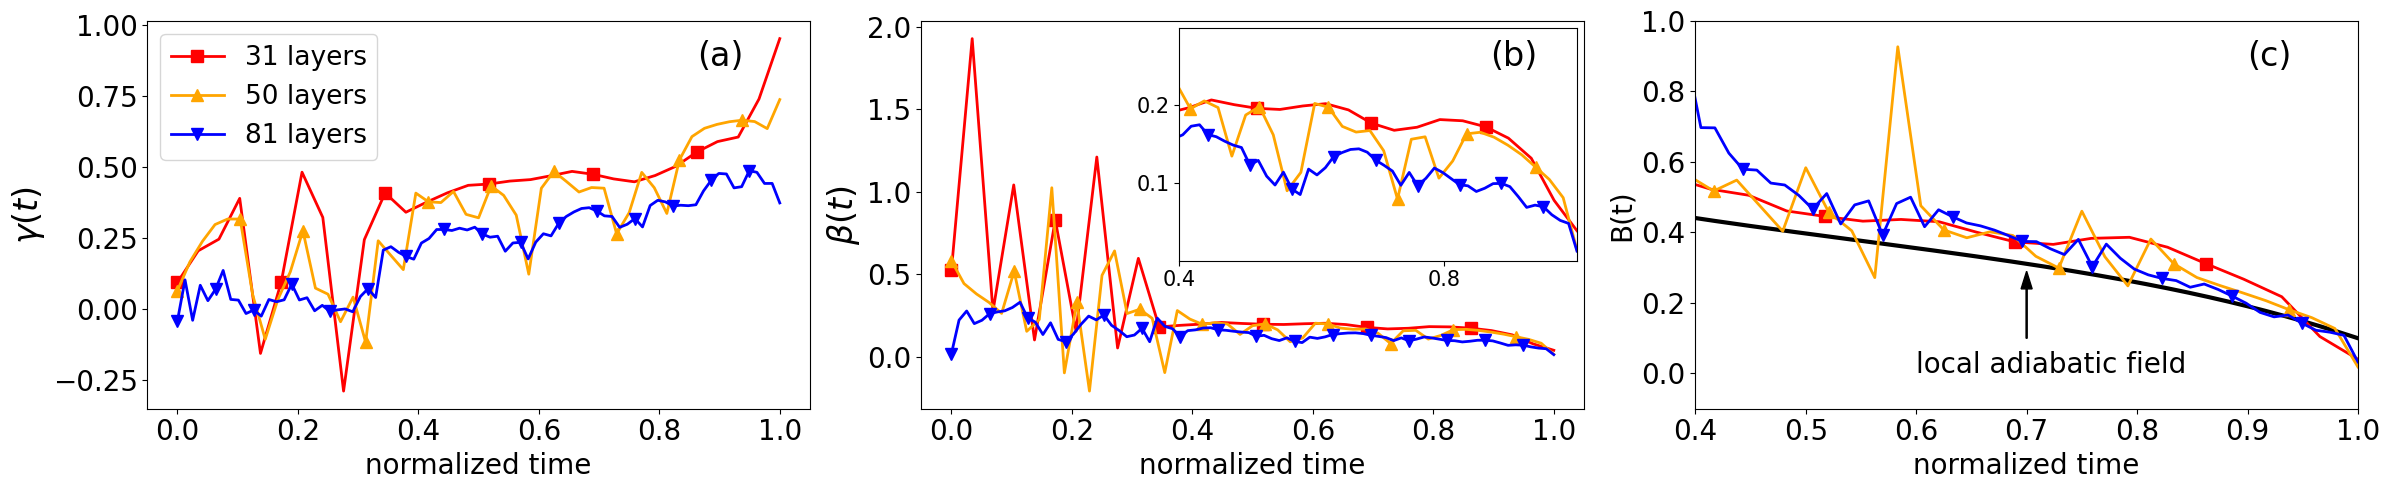

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Assuming your data arrays are defined as best_x_30, best_x_50, best_x_80

# Create a 1x3 subplot
fig, axs = plt.subplots(1, 3, figsize=(24, 5))

# First plot
axs[0].plot(np.linspace(0, 1, len(best_x_30[:30])), best_x_30[:30], color='red', linewidth=2, linestyle='-', markevery=5,marker='s', markersize=8, label='31 layers')
axs[0].plot(np.linspace(0, 1, len(best_x_50[:49])), best_x_50[:49], color='orange', linewidth=2, linestyle='-',markevery=5, marker='^', markersize=8, label='50 layers')
axs[0].plot(np.linspace(0, 1, len(best_x_80[:80])), best_x_80[:80], color='blue', linewidth=2, linestyle='-', markevery=5,marker='v', markersize=8, label='81 layers')

axs[0].set_xticks(np.arange(0, 1.2, 0.2))
axs[0].tick_params(axis='x', labelsize=20)
axs[0].tick_params(axis='y', labelsize=20)
axs[0].set_xlabel('normalized time', fontsize=20)
axs[0].set_ylabel(r'$\gamma (t)$', fontsize=24, color='black')
axs[0].legend(fontsize=19)

# Insert labels
# axs[0].text(x=0.8, y=0.15, s='80 layers', color='blue', fontsize=15, ha='center')
# axs[0].text(x=0.5, y=0.0, s='50 layers', color='orange', fontsize=15, ha='center')
# axs[0].text(x=0.85, y=0.75, s='30 layers', color='red', fontsize=15, ha='center')

# Second plot
axs[1].plot(np.linspace(0, 1, len(best_x_30[31:])), best_x_30[31:], color='red', linewidth=2, linestyle='-', markevery=5,marker='s', markersize=8, label='31 layers')
axs[1].plot(np.linspace(0, 1, len(best_x_50[50:])), best_x_50[50:], color='orange', linewidth=2, linestyle='-', markevery=5,marker='^', markersize=8, label='50 layers')
axs[1].plot(np.linspace(0, 1, len(best_x_80[81:])), best_x_80[81:], color='blue', linewidth=2, linestyle='-', markevery=5,marker='v', markersize=8, label='81 layers')

# Adjust x-axis ticks and font size
axs[1].set_xticks(np.arange(0, 1.2, 0.2))
axs[1].tick_params(axis='x', labelsize=20)

# Set y-axis ticks and adjust font size
axs[1].tick_params(axis='y', labelsize=20)

# Set x-axis label with adjusted font size
axs[1].set_xlabel('normalized time', fontsize=20)

# Set y-axis label with adjusted font size
axs[1].set_ylabel(r'$\beta (t)$', fontsize=24, color='black')

# Add inset plot
ax_inset = inset_axes(axs[1], width="60%", height="60%", loc='upper right')
ax_inset.plot(np.linspace(0, 1, len(best_x_30[31:])), best_x_30[31:], color='red', linewidth=2, linestyle='-',markevery=5, marker='s', markersize=8)
ax_inset.plot(np.linspace(0, 1, len(best_x_50[50:])), best_x_50[50:], color='orange', linewidth=2, linestyle='-',markevery=5, marker='^', markersize=8)
ax_inset.plot(np.linspace(0, 1, len(best_x_80[81:])), best_x_80[81:], color='blue', linewidth=2, linestyle='-',markevery=5, marker='v', markersize=8)
ax_inset.set_xlim(0.4, 1)
ax_inset.set_ylim(0, 0.3)

# Adjust inset plot x-axis ticks and font size
ax_inset.set_xticks(np.arange(0.4, 1.2, 0.4))
ax_inset.tick_params(axis='x', labelsize=15)

# Adjust inset plot y-axis ticks and font size
ax_inset.set_yticks(np.arange(0.1, 0.3, 0.1))
ax_inset.tick_params(axis='y', labelsize=15)

# Third plot
axs[2].plot(np.linspace(0,1, len(B_data_smooth)), B_data_smooth,color='black',linewidth=3)
axs[2].plot(np.linspace(0, 1, len(y_30)), y_30, color='red', linewidth=2, linestyle='-',markevery=5, marker='s', markersize=8, label='31 layers')
axs[2].plot(np.linspace(0, 1, len(y_50)), y_50, color='orange', linewidth=2, linestyle='-',markevery=5, marker='^', markersize=8, label='50 layers')
axs[2].plot(np.linspace(0, 1, len(y_80)), y_80, color='blue', linewidth=2, linestyle='-',markevery=5, marker='v', markersize=8, label='81 layers')

# Adjust y-axis limits
axs[2].set_ylim(-0.1, 1)

# Adjust x-axis limits
axs[2].set_xlim(0.4, 1)

# Set x-axis ticks and font size
axs[2].tick_params(axis='x', labelsize=20)

# Set y-axis ticks and font size
axs[2].tick_params(axis='y', labelsize=20)

# Set x-axis label with adjusted font size
axs[2].set_xlabel('normalized time', fontsize=20)

# Set y-axis label with adjusted font size
axs[2].set_ylabel('B(t)', fontsize=20)

# Add text and arrow
axs[2].text(0.6, 0.00, 'local adiabatic field', color='black', size=20)
axs[2].arrow(0.7, 0.1, 0, 0.14, head_width=0.01, head_length=0.05, fc='black', ec='black', linewidth=1)

# Add labels
axs[0].text(0.90, 0.95, '(a)', transform=axs[0].transAxes, fontsize=24, va='top', ha='right')
ax_inset.text(0.90, 0.95, '(b)', transform=ax_inset.transAxes, fontsize=24, va='top', ha='right')
axs[2].text(0.90, 0.95, '(c)', transform=axs[2].transAxes, fontsize=24, va='top', ha='right')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig('fig_2.pdf')
